In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, average_precision_score, precision_recall_curve, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load the data
file_paths = [
    'Binary Labeled Data/bag_toss_binary.csv',
    'Binary Labeled Data/sitting_up_and_down_binary.csv',
    'Binary Labeled Data/stairs_binary.csv',
    'Binary Labeled Data/standing_binary.csv',
    'Binary Labeled Data/walking_binary.csv'
]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
combined_data = pd.concat(data_frames)



In [6]:
# Preprocess the data
data_for_model = combined_data.drop(columns=['timestamp'])  # Drop timestamp
X = data_for_model.drop(columns=['label'])
y = data_for_model['label'].values

# use standard scaler to process data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)


sequence_length = 60
step = 5

# Sequence data function
def create_sequences(X, y, sequence_length, step, fall_detection_threshold):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length, step):
        seq = X[i: i + sequence_length]
        seq_labels = y[i: i + sequence_length]
        
        # Label the sequence as a fall if the fall_detection_threshold is met
        if np.mean(seq_labels) >= fall_detection_threshold:
            label = 1  # Fall detected
        else:
            label = 0  # No fall detected
        
        X_seq.append(seq)
        y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)

# Sequence the data
X_sequences, y_sequences = create_sequences(X_scaled, y, sequence_length, step, 0.2)

# Reshaping for LSTM
X_sequences = X_sequences.reshape((X_sequences.shape[0], sequence_length, X_scaled.shape[1]))


# Now, X_sequences and y_sequences can be used for training the LSTM model
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)



# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


# Convert class weights to a dictionary to pass to Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

# Setup model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Updated for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Introduce early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with binary labels
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], batch_size=64, class_weight=class_weight_dict)

# Save the model and preprocessors
model.save('LSTM_model_binary.keras')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and preprocessors saved successfully.")


37/37 [==============================] - 1s 10ms/step
F1 Score: 0.9609080266630269
Precision: 0.9839761052303861
Recall: 0.9477739726027398
AUC-ROC: 0.978186775732788
MCC: 0.5389017594757198
Balanced Accuracy: 0.9732690622261174
Average Precision: 0.4797644220440259


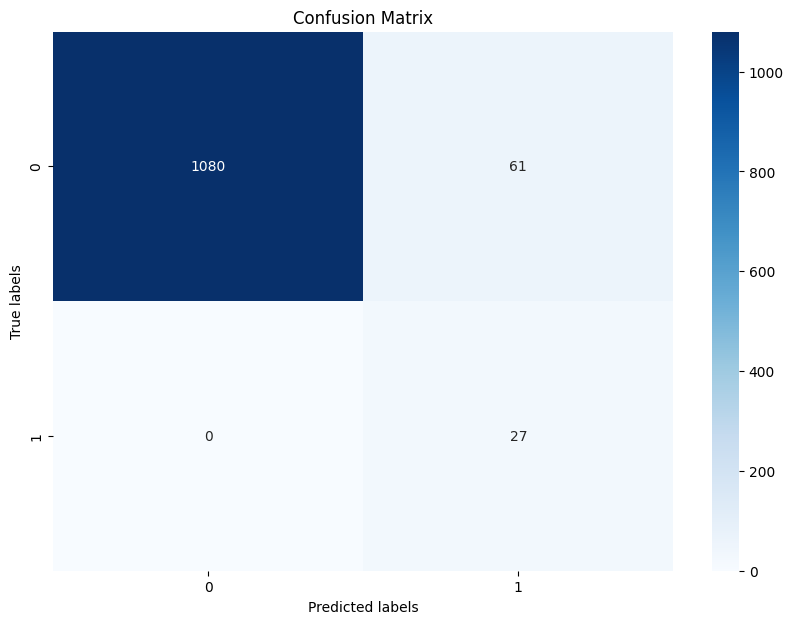

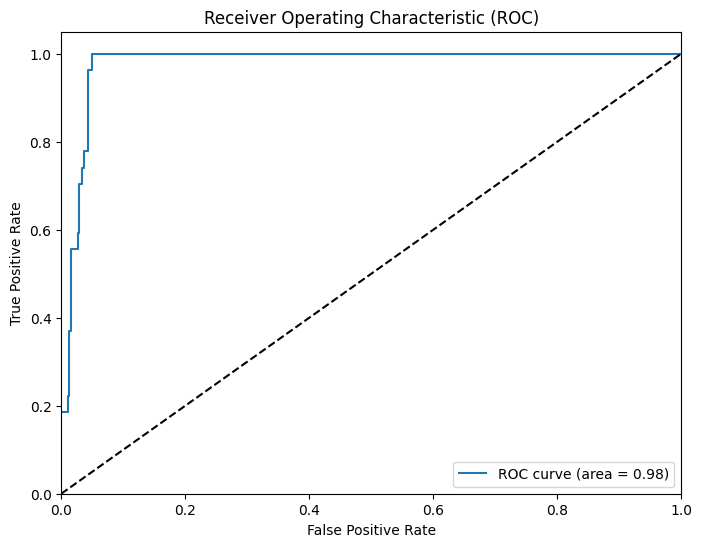

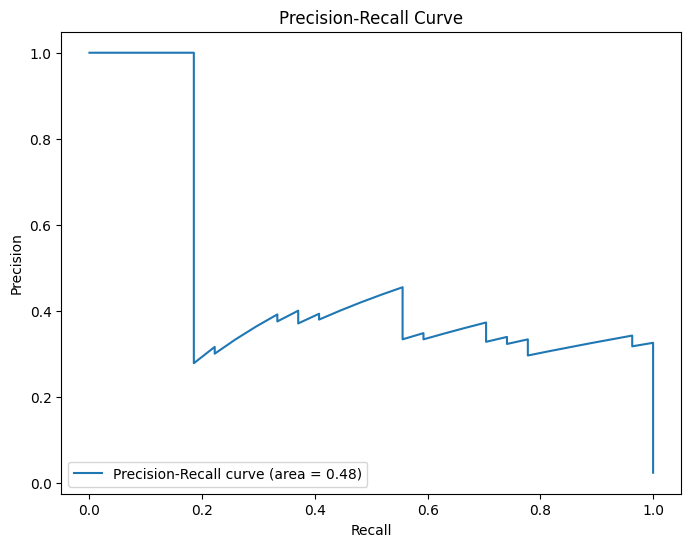

In [5]:

# Predict the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


# Calculate metrics
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_prob)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred_prob)


# Display the metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")
print(f"MCC: {mcc}")
print(f"Balanced Accuracy: {balanced_acc}")
print(f"Average Precision: {average_precision}")

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot it
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



In [4]:
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('LSTM_model_binary.keras')
# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

